# Calculate genetic diversity using scikit-allel on real datasets

In [1]:
import os
import allel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


input_folder = "/shared/projects/almond_dw_snp/1_VariantCalling/results"
suffix = ".filtered.syn.noadmixed"

df = allel.read_vcf(os.path.join(input_folder, "Almond_tree_AllSites" + suffix + ".vcf.gz"))
samples = df['samples']

pop_file = "Almond_tre_popmap_tab.txt" 
pop_data = pd.read_csv(pop_file, sep="\t", header=None, names=["sample", "population"])
# Créer le dictionnaire de populations
populations = pop_data.groupby("population")["sample"].apply(list).to_dict()


/shared/home/amesnil/.local/lib/python3.12/site-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">\n'
  warnings.warn('invalid INFO header: %r' % header)


In [2]:
window_size = 100000

# Dictionnaire pour stocker la diversité π de chaque fichier/réplica

pi_values = {}
He_values = {}
Ho_values = {}

chromosomes = ['Pd01','Pd02','Pd03','Pd04','Pd05', 'Pd06', 'Pd07','Pd08']

for pop_name, pop_samples in populations.items():
    
    # Trouver les indices des échantillons pour cette population
    indices = [np.where(samples == sample)[0][0] for sample in pop_samples if sample in samples]

    if not indices:
        print(f"Aucun échantillon trouvé pour la population {pop_name}")
        continue
        
    for chrom in chromosomes:
        
        # Filtrer les données pour le chromosome actuel
        chrom_mask = df['variants/CHROM'] == chrom
        positions = df['variants/POS'][chrom_mask]
        
        if len(positions) == 0:
            print(f"Aucune position trouvée pour le chromosome {chrom} dans la population {pop_name}")
            continue
        
        maxPosition = positions.max()

        # Extraire les génotypes pour la population et le chromosome actuels
        genotypes = df['calldata/GT'][chrom_mask][:, indices, :]
        gt = allel.GenotypeArray(genotypes)
        haplotypes = allel.GenotypeArray(gt).to_haplotypes()

        # Compter les allèles
        ac = haplotypes.count_alleles()

        # Calculer π pour chaque fenêtre
        pi, windows, n_bases, counts = allel.windowed_diversity(positions, ac, size=window_size, start=1, stop = maxPosition)
                
        ho = gt.is_het().mean(axis=1)
        # print(ho)
        he = 1 - (ac.to_frequencies() ** 2).sum(axis=1)
        # print(he)

        # Ajouter les valeurs de π au dictionnaire
        if (pop_name, chrom) not in pi_values:
            pi_values[(pop_name, chrom)] = []
        pi_values[pop_name, chrom].extend(pi)

        if (pop_name, chrom) not in He_values:
            He_values[(pop_name, chrom)] = []
        He_values[pop_name, chrom].extend(he)

        if (pop_name, chrom) not in Ho_values:
            Ho_values[(pop_name, chrom)] = []
        Ho_values[pop_name, chrom].extend(ho)

In [4]:
print(pi_values.keys())
# Préparation des données pour le boxplot
pi_df = pd.DataFrame([(pop, chrom, value) for (pop, chrom), values in pi_values.items() for value in values],
                     columns=['Population', 'Chromosome', 'Pi'])

ho_df = pd.DataFrame([(pop, chrom, value) for (pop, chrom), values in Ho_values.items() for value in values],
                     columns=['Population', 'Chromosome', 'Ho'])

he_df = pd.DataFrame([(pop, chrom, value) for (pop, chrom), values in He_values.items() for value in values],
                     columns=['Population', 'Chromosome', 'He'])

pd.DataFrame(pi_df, columns=['Population', 'Chromosome', 'Pi']).to_csv(
    os.path.join(input_folder, 'pi_values_in_real_pops.csv'), sep=',', index=False, mode='a', header=False
    )
pd.DataFrame(ho_df, columns=['Population', 'Chromosome', 'Ho']).to_csv(
    os.path.join(input_folder, 'ho_values_in_real_pops.csv'), sep=',', index=False, mode='a', header=False
    )
pd.DataFrame(he_df, columns=['Population', 'Chromosome', 'He']).to_csv(
    os.path.join(input_folder, 'he_values_in_real_pops.csv'), sep=',', index=False, mode='a', header=False
    )


dict_keys([('Pdulcis_C_Asia', 'Pd01'), ('Pdulcis_C_Asia', 'Pd02'), ('Pdulcis_C_Asia', 'Pd03'), ('Pdulcis_C_Asia', 'Pd04'), ('Pdulcis_C_Asia', 'Pd05'), ('Pdulcis_C_Asia', 'Pd06'), ('Pdulcis_C_Asia', 'Pd07'), ('Pdulcis_C_Asia', 'Pd08'), ('Pdulcis_Euro_1', 'Pd01'), ('Pdulcis_Euro_1', 'Pd02'), ('Pdulcis_Euro_1', 'Pd03'), ('Pdulcis_Euro_1', 'Pd04'), ('Pdulcis_Euro_1', 'Pd05'), ('Pdulcis_Euro_1', 'Pd06'), ('Pdulcis_Euro_1', 'Pd07'), ('Pdulcis_Euro_1', 'Pd08'), ('Pdulcis_Euro_2', 'Pd01'), ('Pdulcis_Euro_2', 'Pd02'), ('Pdulcis_Euro_2', 'Pd03'), ('Pdulcis_Euro_2', 'Pd04'), ('Pdulcis_Euro_2', 'Pd05'), ('Pdulcis_Euro_2', 'Pd06'), ('Pdulcis_Euro_2', 'Pd07'), ('Pdulcis_Euro_2', 'Pd08'), ('Pdulcis_N_Amer', 'Pd01'), ('Pdulcis_N_Amer', 'Pd02'), ('Pdulcis_N_Amer', 'Pd03'), ('Pdulcis_N_Amer', 'Pd04'), ('Pdulcis_N_Amer', 'Pd05'), ('Pdulcis_N_Amer', 'Pd06'), ('Pdulcis_N_Amer', 'Pd07'), ('Pdulcis_N_Amer', 'Pd08'), ('Pfenzliana', 'Pd01'), ('Pfenzliana', 'Pd02'), ('Pfenzliana', 'Pd03'), ('Pfenzliana', 'Pd04'

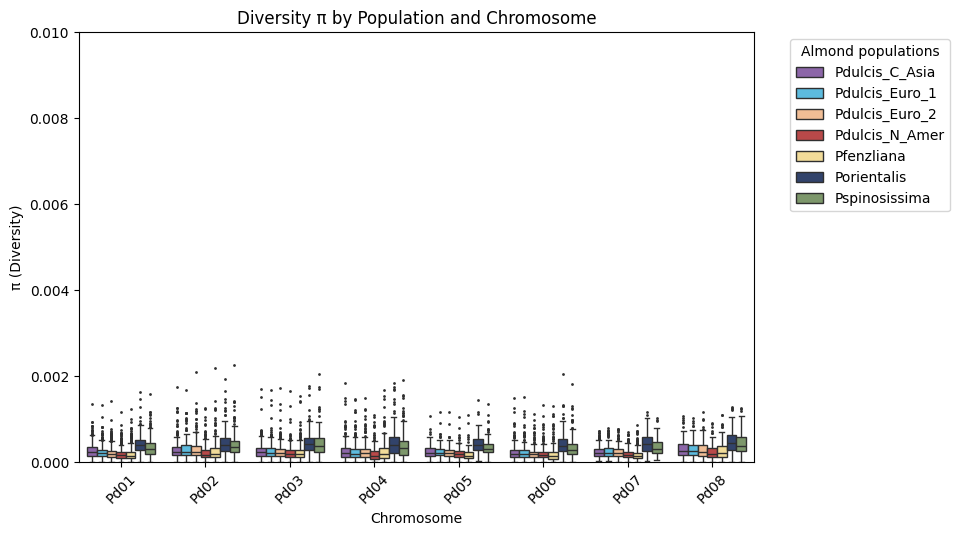

In [5]:
couleurs = {
    'Pdulcis_C_Asia': '#8d5bb3',
    'Pdulcis_Euro_1': '#47c5f3',
    'Pdulcis_Euro_2': '#ffbb86',
    'Pdulcis_N_Amer': '#cb3636',
    'Pfenzliana': '#ffe38b',
    'Porientalis': '#283f75',
    'Pspinosissima': '#7b9e64'
}

# Création des boxplots pour π, Ho et He
plt.figure(figsize=(10, 15))

# Boxplot pour π
plt.subplot(3, 1, 1)
sns.boxplot(x='Chromosome', y='Pi', hue='Population', palette=couleurs, data=pi_df, fliersize=1)
plt.title('Diversity π by Population and Chromosome')
plt.ylabel('π (Diversity)')
plt.xticks(rotation=45)
plt.ylim(0,0.01)
plt.legend(title='Almond populations', bbox_to_anchor=(1.3, 1), ncol=1)  # Ajuste selon tes besoins

plt.tight_layout()
plt.show()

In [ ]:
# Boxplot pour Ho
plt.subplot(3, 1, 2)
sns.boxplot(x='Population', y='Ho', hue='Chromosome', data=ho_df)
plt.title('Observed Heterozygosity Ho by Population and Chromosome')
plt.ylabel('Ho (Observed Heterozygosity)')
plt.xticks(rotation=45)

# Boxplot pour He
plt.subplot(3, 1, 3)
sns.boxplot(x='Population', y='He', hue='Chromosome', data=he_df)
plt.title('Expected Heterozygosity He by Population and Chromosome')
plt.ylabel('He (Expected Heterozygosity)')
plt.xticks(rotation=45)